In [ ]:
## Based on code at
#  - https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html
## Also see:
#  - https://machinelearningmastery.com/what-is-bayesian-optimization/
#  - https://distill.pub/2020/bayesian-optimization/

In [1]:
%matplotlib inline

In [3]:
## Install as needed
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 46 kB/s ta 0:00:01



# Bayesian optimization with `skopt`

Gilles Louppe, Manoj Kumar July 2016.
Reformatted by Holger Nahrstaedt 2020

.. currentmodule:: skopt

## Problem statement

We are interested in solving

\begin{align}x^* = arg \min_x f(x)\end{align}

under the constraints that

- $f$ is a black box for which no closed form is known
  (nor its gradients);
- $f$ is expensive to evaluate;
- and evaluations of $y = f(x)$ may be noisy.

**Disclaimer.** If you do not have these constraints, then there
is certainly a better optimization algorithm than Bayesian optimization.

This example uses :class:`plots.plot_gaussian_process` which is available
since version 0.8.

## Bayesian optimization loop

For $t=1:T$:

1. Given observations $(x_i, y_i=f(x_i))$ for $i=1:t$, build a
   probabilistic model for the objective $f$. Integrate out all
   possible true functions, using Gaussian process regression.

2. optimize a cheap acquisition/utility function $u$ based on the
   posterior distribution for sampling the next point.
   $x_{t+1} = arg \min_x u(x)$
   Exploit uncertainty to balance exploration against exploitation.

3. Sample the next observation $y_{t+1}$ at $x_{t+1}$.


## Acquisition functions

Acquisition functions $u(x)$ specify which sample $x$: should be
tried next:

- Expected improvement (default):
  $-EI(x) = -\mathbb{E} [f(x) - f(x_t^+)]$
- Lower confidence bound: $LCB(x) = \mu_{GP}(x) + \kappa \sigma_{GP}(x)$
- Probability of improvement: $-PI(x) = -P(f(x) \geq f(x_t^+) + \kappa)$

where $x_t^+$ is the best point observed so far.

In most cases, acquisition functions provide knobs (e.g., $\kappa$) for
controlling the exploration-exploitation trade-off.
- Search in regions where $\mu_{GP}(x)$ is high (exploitation)
- Probe regions where uncertainty $\sigma_{GP}(x)$ is high (exploration)


In [4]:
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


## Toy example

Let assume the following noisy function $f$:



In [14]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) \
           + np.random.randn() * noise_level


**Note.** In `skopt`, functions $f$ are assumed to take as input a 1D
vector $x$: represented as an array-like and to return a scalar
$f(x)$:.



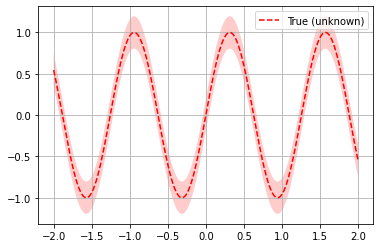

In [15]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

Bayesian optimization based on gaussian process regression is implemented in
:class:`gp_minimize` and can be carried out as follows:



In [16]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

Accordingly, the approximated minimum is found to be:



In [17]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=1.0019, f(x^*)=-1.1122'

For further inspection of the results, attributes of the `res` named tuple
provide the following information:

- `x` [float]: location of the minimum.
- `fun` [float]: function value at the minimum.
- `models`: surrogate models used for each iteration.
- `x_iters` [array]:
  location of function evaluation for each iteration.
- `func_vals` [array]: function value for each iteration.
- `space` [Space]: the optimization space.
- `specs` [dict]: parameters passed to the function.



In [18]:
print(res)

          fun: -1.1121897630505762
    func_vals: array([-0.1016967 ,  0.21955974,  0.94017496, -0.67312655,  0.93181798,
       -1.11218976, -0.92480335, -0.36793422,  0.95832219, -0.84072408,
        0.48650594, -0.60384929, -0.90983982, -0.96329364, -0.6149741 ])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True

Together these attributes can be used to visually inspect the results of the
minimization, such as the convergence trace or the acquisition function at
the last iteration:



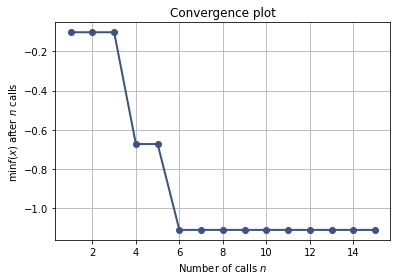

In [19]:
from skopt.plots import plot_convergence
plot_convergence(res);

Let us now visually examine

1. The approximation of the fit gp model to the original function.
2. The acquisition values that determine the next point to be queried.



In [20]:
plt.rcParams["figure.figsize"] = (8, 14)


def f_wo_noise(x):
    return f(x, noise_level=0)

Plot the 5 iterations following the 5 random points



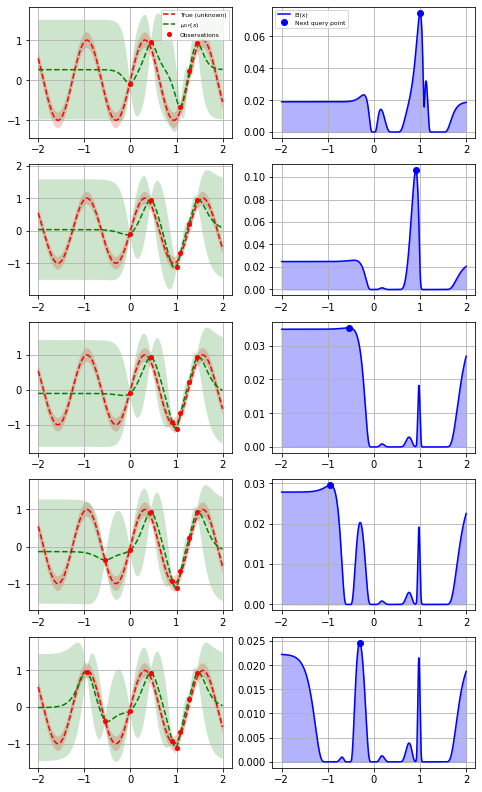

In [21]:
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plotgaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

The first column shows the following:

1. The true function.
2. The approximation to the original function by the gaussian process model
3. How sure the GP is about the function.

The second column shows the acquisition function values after every
surrogate model is fit. It is possible that we do not choose the global
minimum but a local minimum depending on the minimizer used to minimize
the acquisition function.

At the points closer to the points previously evaluated at, the variance
dips to zero.

Finally, as we increase the number of points, the GP model approaches
the actual function. The final few points are clustered around the minimum
because the GP does not gain anything more by further exploration:



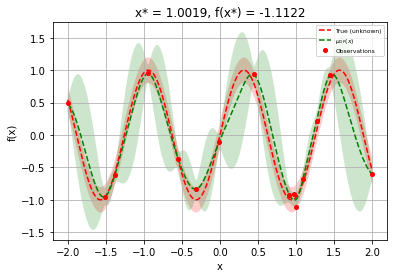

In [22]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=noise_level)

plt.show()

## Larger Example

In [23]:
def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

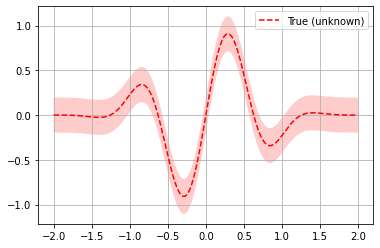

In [24]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [25]:
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [26]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.3818, f(x^*)=-0.8385'

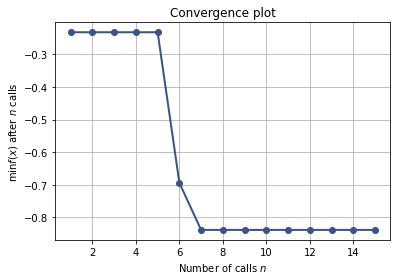

In [28]:
plot_convergence(res);

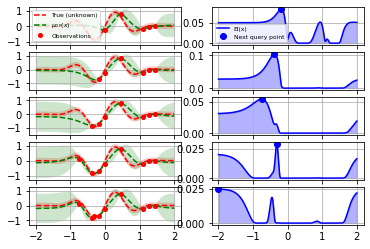

In [29]:
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

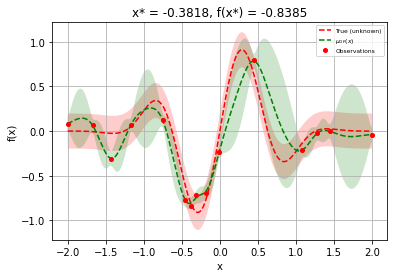

In [30]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=noise_level)

plt.show()